In [11]:
from datetime import datetime
import pandas as pd   # 추출된 자료를 데이터 프레임 형태로 사용하기 위한 라이브러리 호출 (Call library for cursor to dataframe)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


from pyhive import presto   # Hive와 연결하기 위한 라이브러리 호출 (Call library for connection to Hive)
from requests.auth import HTTPBasicAuth   # Hive 계정인증을 위한 라이브러리 호출

In [12]:
matplotlib.rcParams['font.family'] = 'NanumMyeongjo' # Windows  나눔명조
# matplotlib.rcParams['font.family'] = 'AppleGothic' # Mac
matplotlib.rcParams['font.size'] = 10 # 글자 크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

In [13]:
var_id = 'dopark41'   # Hive ID
var_ps = 'rbqlschlrh23###'   # Hive Password
var_db = 'hive'   # DataBase Name (변경할 필요없음 / No need to change)
var_url = 'cfs-presto.coupang.net'   # DataBase URL (변경할 필요없음 / No need to change)



# Connection Type 2

conn = presto.connect(host=var_url, port=443, protocol='https', catalog=var_db, username=var_id, password=var_ps)



cur = conn.cursor()   # Cursor for Query Sending to DB # 접속 커서를 만드는 코드


### Alternative Connection 
# 구동문


In [14]:
# Test Query
query =\
'''
SELECT * FROM (WITH PICK as(WITH pick as(SELECT DISTINCT * FROM (SELECT date(INV.createdat) date
			,hour(INV.createdat) Timerange
			,INV.description
			,LOT.fullname
			,LOC.floor
			,SKU.id AS skuid
			,SKU.externalid AS externalskuid
			,SKU.name 
			,abs(INV.quantity) qty
			,(abs(INV.quantity)*SKU.weight)/1000 as "weight(kg)"
			,SKU.capacitytype
			,CAST(usr.userid AS int) userid
FROM hive . ods . inventory_logs AS INV
INNER JOIN HIVE.ODS.LOTS      LOT ON LOT.ID = INV.LOTID
INNER JOIN HIVE.ODS.LOCATIONS LOC ON LOC.ID = LOT.LOCATIONID
INNER JOIN HIVE.ODS.SKUS      SKU ON SKU.ID = INV.SKUID
INNER JOIN HIVE.ODS.CENTERS   CEN ON CEN.ID = LOT.CENTERID
INNER JOIN ods.wms_users as usr on inv.workeruserid = usr.id
WHERE 1 = 1
AND CEN.ID IN (108)
AND date(inv.createdat) = cast(current_date as date) 
AND inv.TYPE = 'TAKEAWAY'
AND inv.adjusttype = 'REMOVE'
AND INV.description NOT LIKE '%Andon 파괴검수%'))
SELECT Timerange, floor, userid, CASE WHEN qty > 0 THEN 'pick'
     	 ELSE '' END AS type, count(fullname) plt  
	FROM pick
	GROUP BY 1,2,3,4),
	STOW AS(select HOUR(s.createdat) Timerange
		,CASE WHEN s.locationbarcode LIKE('108-0%') THEN '0.5'
		 			WHEN s.locationbarcode LIKE('108-1%') THEN '1'
		 			WHEN s.locationbarcode LIKE('108-3%') THEN '3'
		 			WHEN s.locationbarcode LIKE('108-4%') THEN '4'
		 			ELSE '' END as floor
    ,CAST(A.userid AS int) userid
		,CASE WHEN s.quantity > 0 THEN 'stow'
     	 ELSE '' END AS type
    ,count(s.quantity) plt
    from ods.stow_work_logs s
    JOIN ODS.WMS_USERS A ON (s.WORKERUSERID = A.ID)
    where s.centerid = 108
    and cast(s.createdat as date) = cast(current_date as date)
    and s.eventtype = 'STOW'
    and s.message = 'SUCCESS'
    GROUP BY 1,2,3,4)
SELECT * FROM PICK
UNION
SELECT * FROM STOW)
ORDER BY 1,2,3,4
'''

cur.execute(query)   # Query를 실행 (Execute query)
df = pd.DataFrame(cur.fetchall(), columns=[ix[0] for ix in cur.description])  # 실행된 Query에서 추출된 자료를 DataFrame형태로 전달 (Send executed query to DataFrame)

conn.close()   # Close DataBase connection (추출완료 후, 연결종료를 실행해야 다른 프로그램에서 DataBase 접속이 가능해집니다) # 접속 종료 코드

In [15]:
df2 = pd.read_excel(r"C:\Users\dopark41\OneDrive - Coupang Fulfillment Services\Attachments\GON2_RC2\05. Report\Employee.xlsx")

In [16]:
df2 = df2.rename(columns={'이름':'name', '사용자 ID':'userid'})
df2 = df2[['name', 'userid']]

In [20]:
mdf = pd.merge(left=df, right=df2, on='userid', how='left')
mdf = mdf[['Timerange', 'floor', 'name', 'type', 'plt']]

# sum 함수
sum_throughput = mdf.groupby('Timerange')['plt'].sum() # Timerange 기준으로 그룹
sum_throughput

Timerange
11    1
15    7
Name: plt, dtype: int64

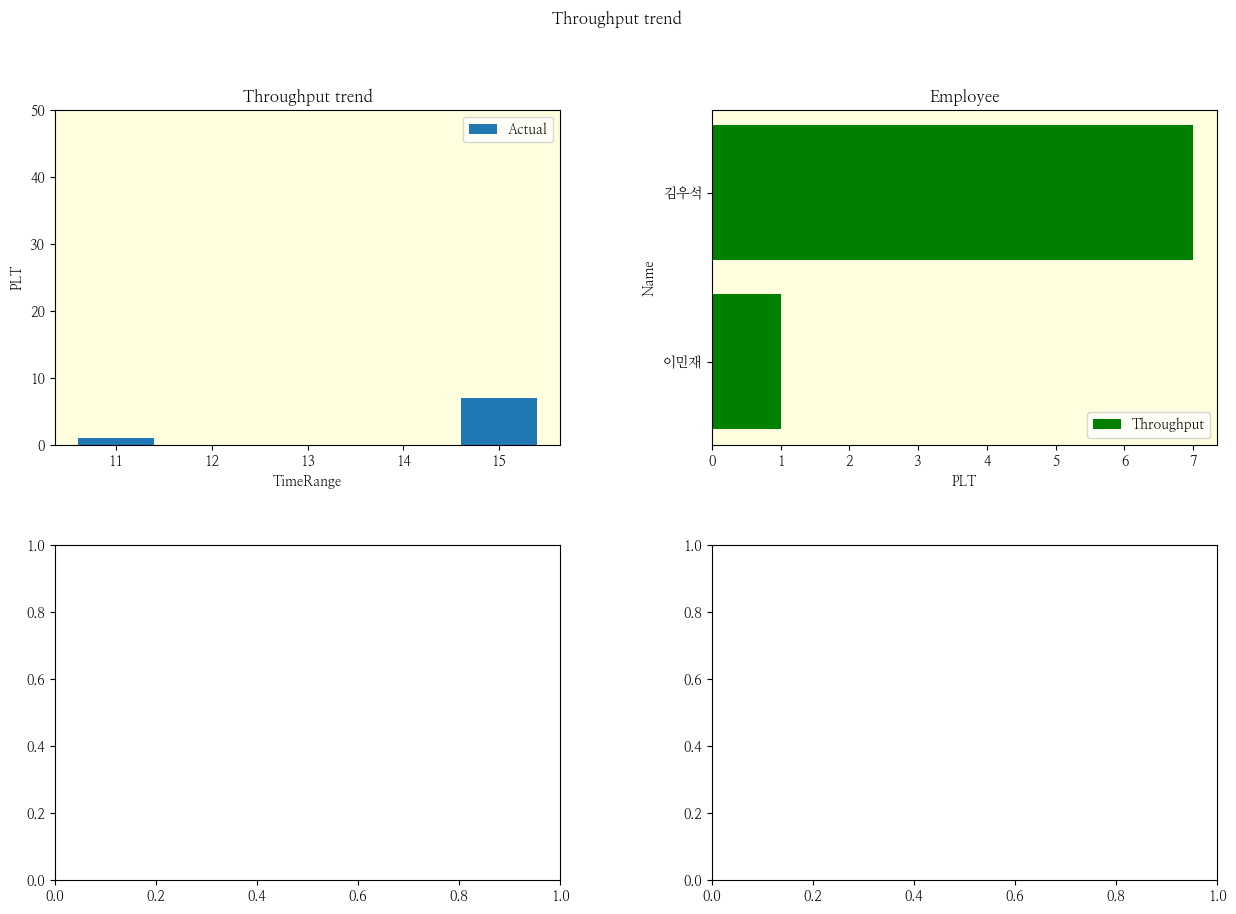

In [18]:
fig, axs = plt.subplots(2, 2) # 2 x 2 에 해당하는 plot 들을 생성
# 격자 크기 설정
fig.set_size_inches((15, 10))
# 격자 여백 설절
plt.subplots_adjust(wspace=0.3, hspace=0.3)

fig.suptitle('Throughput trend')

bar = axs[0, 0].bar(mdf['Timerange'], sum_throughput, label='Actual')
axs[0, 0].set_title('Throughput trend') # 제목
axs[0, 0].set_ylim(0,50)
axs[0, 0].legend() # 범례
axs[0, 0].set(xlabel='TimeRange', ylabel='PLT') #
axs[0, 0].set_facecolor('lightyellow') # 전경

bar = axs[0, 1].barh(mdf['name'], sum_throughput, label='Throughput', color='g')
axs[0, 1].set_title('Employee') # 제목
axs[0, 1].legend() # 범례
axs[0, 1].set(xlabel='PLT', ylabel='Name') #
axs[0, 1].set_facecolor('lightyellow') # 전경

plt.show()


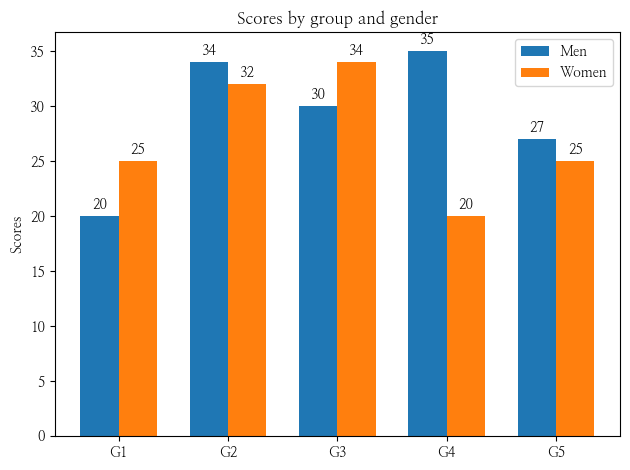

In [19]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')
# 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
# 
fig.tight_layout()

plt.show()